<a href="https://colab.research.google.com/github/GruAna/VU/blob/master/m_tesseract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tesseract

## Packages

In [21]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install imgaug==0.2.6
!pip install --ignore-installed Pillow==9.0.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-9.0.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)


In [2]:
import pytesseract
from pytesseract import Output
import os
import cv2 as cv
import numpy as np
import pandas as pd

from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!cp drive/MyDrive/Colab_Notebooks/VU/utils.py .
from utils import *

## Setup

In [3]:
# whether images are to be resized (skrinking)
resize = True
width = 3000

## Dataset loading

**CTW1500 dataset**

Get images. Update location of images **manually**.

In [4]:
# path to image directory, get full path to all files
imgs_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/CTW1500/train_images'
(_, _, filenames) = next(os.walk(imgs_dir))
filenames.sort()
list_img_paths = [os.path.join(imgs_dir, file) for file in filenames]
n_imgs = len(list_img_paths)

In [5]:
# load images
original_images = [cv.imread(file) for file in list_img_paths]

In [6]:
# shrink images
if resize:
    images = shrink_all(original_images, width)
else:
    images = original_images.copy()

# grayscale
images = [cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in images]

# threshold
patches = [(img.shape[0] // 16) * 2 + 1 for img in images]
images = [cv.adaptiveThreshold(images[i], 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, patches[i], 5) for i in range(n_imgs)]
# # closing 
# kernel = cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
# images = [cv.morphologyEx(img, cv.MORPH_CLOSE, kernel) for img in images]

Get paths to files with labels. Update location **manually**.

In [8]:
labels_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/CTW1500/ctw1500_train_labels'
(_, _, xml_files) = next(os.walk(labels_dir))
xml_files.sort()
list_xml_paths = [os.path.join(labels_dir, file) for file in xml_files]

Get ground truths from all xml files

In [9]:
ground_truth = []

# if images where resized we need to resize also the coordinates in gt
if resize:
    for i, file in enumerate(list_xml_paths):
        ratio = width / original_images[i].shape[1]
        if ratio > 1:
            ratio = 1
        ground_truth.append(read_gt_ctw_train(file, scaling_ratio=ratio))
else:
    for i, file in enumerate(list_xml_paths):
        ground_truth.append(read_gt_ctw_train(file))

# ground_truth is in the is a list of tuples, where first is the gt word 
# and second is an array of top left and bottom right coordinates

## Prediction

Run OCR method.

In [10]:
# loop through all images in image directory

predictions = []
custom_config = r'--oem 3 --psm 11'

for img in tqdm(images):
    output = pytesseract.image_to_data(img, output_type=Output.DICT, config=custom_config)

    predictions.append(output)

100%|██████████| 1000/1000 [50:30<00:00,  3.03s/it]


## Results postprocessing

Calculate bounding rectangles for detected words in an image.

For all images.

Replace polygon coordinates by these two rectangle coordinates.

In [11]:
# gather non empty predictions in a list of tuples (word, bounding_box_coordinates)
# predicted contains all images, each image can have multiple recognized words
# each image contains tuples in mentioned format

# in PyTesseract image_to_data returns a dictionary with results

predicted = []
for img in range(n_imgs):
    result = predictions[img]

    n = len(result['text'])
    results = []
    for i in range(n):
        word = result['text'][i]

        if len(word) > 0 and not word.isspace():
            coordinates = np.array([[result['left'][i],  result['top'][i]], [result['left'][i] +  result['width'][i], result['top'][i] + result['height'][i]]])
            results.append((word, coordinates))

    predicted.append(results)

Compare bounding boxes of predicition and ground truth.

Count Intersection over Union (IoU) metric for bounding boxes. Store for all images in a list `iou_images`.

Count Character Error Rate (CER) metric for characters in words. Store for all images in a list `cer_images`.

In [102]:
def compare_text_cer(text, special_characters=False, case_sensitive=False):
    """
    Parameters:
    - text: tuple of (ground_truth, predicted)
    - special_characters=False: if False then ignores all characters except alphanumeric
    - case_sensitive=False: if False then interprets text as lowercase 
    """
    gt, pred = text
    # remove special characters and case sensitivity if necessary
    if ~special_characters:
        text_gt = "".join(char for char in gt if (char.isalnum() or char.isspace()))
        text_pred = "".join(char for char in pred if (char.isalnum() or char.isspace()))
    if ~case_sensitive:
        text_gt = text_gt.lower()
        text_pred = text_pred.lower()
    
    # devide text region on single words
    # because one text_... can contain more than one word
    # and there is a possibility that these words are not in correct order
    # space ic the separator
    words_gt = text_gt.split(" ")
    words_pred = text_pred.split(" ")

    # list of words that are corresponding (based on levenshtein distance)
    # and cer value. (=tuple of three elements)
    # for every predicted word find its corresponding gt wordle
    corresponding_words = []
    for word_pred in words_pred:    
        min_dist = (1000, (0, 0))
        min_gt_word = ""                  
        for word_gt in words_gt: 
            l_dist = levenshtein_distance(word_gt, word_pred)
            if l_dist[0] < min_dist[0]:
                min_dist = l_dist
                min_gt_word = word_gt
        # count normalized cer (the result will be from 0 to 1), 1 is the worst
        # for computation we devide Levenshtein dist. by sum 
        # of the length of the word and count of insertions performed
        if len(min_gt_word) > 0 and len(word_pred) > 0:
            cer = min_dist[0] / (len(min_gt_word) + min_dist[1][2])
        else:
            cer = 1
        corresponding_words.append((min_gt_word, word_pred, cer))

    return sorted(corresponding_words)

In [103]:
iou_images = []
cer_images = []

# loop through images:
for i in range(n_imgs):
    if not predicted[i]: 
        iou_text_regions = [0, -1]
        comparision = [('', '', 1)]
    else:
        # separate list on columns (iterate through tuples in the list)
        predicted_cols = list(zip(*predicted[i]))
        ground_truth_cols = list(zip(*ground_truth[i]))
        # take only coordinate arrays from list for each images
        pred_boxes = predicted_cols[1]
        gt_boxes = ground_truth_cols[1]
        iou_from_image = iou_image(pred_boxes, gt_boxes)

        iou_text_regions = group_text(iou_from_image)

        # take only labels for each image
        pred_labels = predicted_cols[0]
        gt_labels = ground_truth_cols[0]

        # compare corresponding labels
        # comparision is a list of all text regions on one image
        comparision = []
        for gt_ind, observation in enumerate(iou_text_regions):
            pred_ind = observation[1]
            predicted_text = " ".join([pred_labels[i] for i in pred_ind])
            gt_pred_text = (gt_labels[gt_ind], predicted_text)

            # comparision for one text region (on one image)
            comparision.append((compare_text_cer(gt_pred_text, special_characters=True, case_sensitive=True)))

    iou_images.append((iou_text_regions))
    cer_images.append((comparision))

### Metrics
Metrics for each image (average of values of all regions in one image).

IoU (detection) `iou_in_image`

CER (recognition) `cer_in_image`

In [124]:
iou_in_image = []
cer_in_image = []

for i in range(n_imgs):
    length = len(cer_images[i])

    # calculate mean based on results 
    if isinstance(cer_images[i][0], list):
        mean_in_regions = average([average(list(zip(*cer_images[i][j]))[2]) for j in range(length)])
        iou_in_image.append(average(list(zip(*iou_images[i]))[0], length=n_imgs))
    elif isinstance(cer_images[i][0], tuple):
        mean_in_regions = cer_images[i][0][-1]
        iou_in_image.append(iou_images[i][0])
    else:
        mean_in_regions = 1
        iou_in_image.append(0)

    cer_in_image.append(mean_in_regions)

In [123]:
i=1
length = len(cer_images[i])

mean_in_regions = average([average(list(zip(*cer_images[i][j]))[2]) for j in range(length)])
mean_in_regions

0.8830339548279519

### Overall results for dataset

In [126]:
df_results = pd.DataFrame(list(zip(filenames, iou_in_image, cer_in_image)), columns =['Filename', 'IoU', 'CER'])
mean_iou = round(df_results['IoU'].mean() * 100, 1)
mean_cer = round((1 - df_results['CER'].mean()) * 100, 1)
print(f"mean IoU accuracy = {mean_iou}%, mean CER accuracy = {mean_cer}%")

df_results

mean IoU accuracy = 0.2%, mean CER accuracy = 15.5%


,Filename,IoU,CER
0,0001.jpg,0.004764,0.394048
1,0002.jpg,0.001325,0.883034
2,0003.jpg,0.004057,0.595888
3,0004.jpg,0.005623,0.753665
4,0005.jpg,0.002762,0.925938
...,...,...,...
995,0996.jpg,0.003332,0.704167
996,0997.jpg,0.001147,0.797037
997,0998.jpg,0.000337,0.816667
998,0999.jpg,0.000730,0.799603


### Save results

In [127]:
# set and create output directory if it doesn't exist

output_dir = 'results'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

Specify unique filename and specification.

Specification is an array of first used method, second some useful infromation.

In [128]:
# SELECT FROM OR CREATE OWN, COMMENT UNUSED:

# basic tesseract (original image size, case insensitive, only alphanumeric)
file_name = "tesseract_CTW_u"
specifications = ["tesseract untrained", "dataset: CTW1500", "original image size, case insensitive, only alphanumeric"]

Save to file.

In [129]:
# create file with results (specify method and other parameters)

with open('%s/result_%s.txt' % (output_dir, file_name), 'w') as output_file:
    output_file.write(": ".join(str(text) for text in specifications))
    output_file.write("\n"+f"iou = {mean_iou}")
    output_file.write("\n"+f"cer = {mean_cer}")

Visualize bounding rectangles and corresponing words.

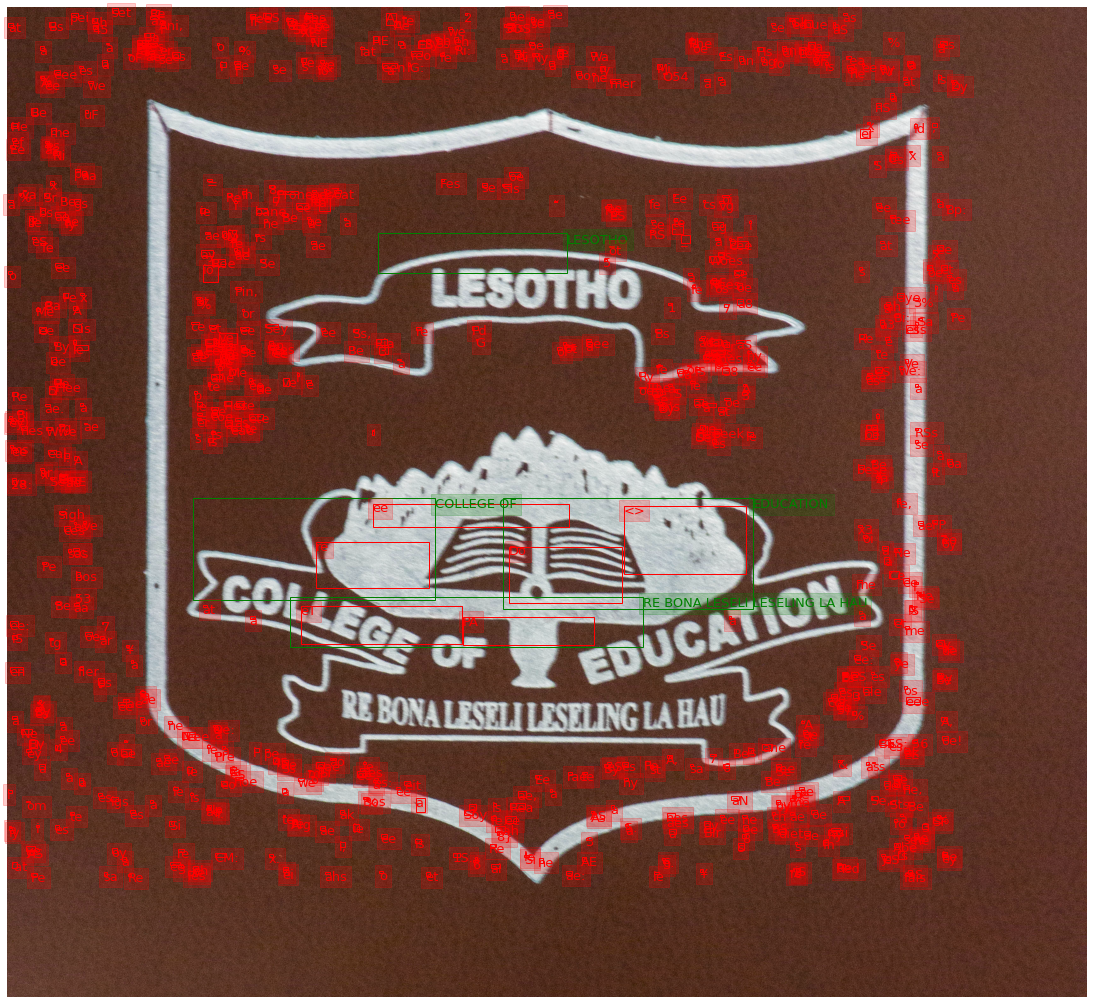

In [138]:
# all images / one sample image
# for i in range(n_imgs):
i = 1

im = plot_results(original_images[i], ground_truth[i], predicted[i])  
im.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

im.savefig('%s/result_%s.png' % (output_dir, file_name))
im.show()
